### **Continuing Model Tuning**<br>
In previous part we decided upon the architecture and tested a different optimizer. We concluded that model 5 and adam optimizer works best.<br>
**In this part we will find the optimum learning rate, following which we will train for longer epochs with various callbacks to avoid overfitting**

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Automatic Ticket Assignment')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, GlobalMaxPool1D, Flatten
from Model.DLModelTuningAndEvaluation import *
from keras.models import load_model
import math
from sklearn.metrics import recall_score, precision_score, classification_report

**Loading GloVeEmbeddingMatrix, train set, train labels, test set and test labels that we saved in Milestone 1 part2b:**

In [ ]:
# USE THIS SAVEPATH IF RUNNING IN GOOGLE COLAB, GIVE THE PATH WHERE YOU WANT TO SAVE
SAVEPATH = '/content/drive/MyDrive/Automatic Ticket Assignment/DataFiles/Milestone2/'
# *************************** --------------------------************************************
# SAVEPATH = 'DataFiles/Milestone2/'

embedding_matrix = np.load(SAVEPATH+'GloveEmbeddingMatrix.npy')
x_train = np.load(SAVEPATH+'xtrain.npy')
y_train = np.load(SAVEPATH+'ytrain.npy')
x_test = np.load(SAVEPATH+'xtest.npy')
y_test = np.load(SAVEPATH+'ytest.npy')

print('JUST TO RECALL\n','train set:',x_train.shape)
print('train labels:',y_train.shape)
print('test set:',x_test.shape)
print('test labels:',y_test.shape,'\n')
print('embedding matrix:',embedding_matrix.shape)

JUST TO RECALL
 train set: (6432, 76)
train labels: (6432, 74)
test set: (1608, 76)
test labels: (1608, 74) 

embedding matrix: (19235, 200)


**This is the model 5 that we finalised:**

In [ ]:
# model5 architecture 
input = Input(shape=(x_train.shape[1],),batch_size=None)
model5 = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=x_train.shape[1], trainable=True)(input)
model5 = LSTM(units=100, return_sequences=True,recurrent_dropout=0.2)(model5) #recurrent dropout
model5 = GlobalMaxPool1D()(model5)
model5 = Dropout(0.2)(model5) #dropout layer
out = Dense(y_train.shape[1], activation="softmax")(model5)
model5 = Model(input, out)
model5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 76, 200)           3847000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 76, 100)           120400    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 74)                7474      
Total params: 3,974,874
Trainable params: 3,974,874
Non-trainable params: 0
_________________________________________________

**Sanity check for model architecture:**<br>
Training for just 1 epoch with a very low learning rate: 1e-5

In [ ]:
train_model(model5, x_train, y_train, x_test, y_test, ep=1, learn_rate=0.00001, bs=16)

402/402 [==============================] - 58s 142ms/step - loss: 4.3301 - accuracy: 0.0172 - val_loss: 4.1452 - val_accuracy: 0.1399


We have 74 classes, hence because of random initilisation of weights, probability of prediction of each class is 1/74 i.e 0.0134. So for any class, log loss/crossentropy loss would be -log_e(0.0134) = 4.31. **We get approximately same loss, hence we pass the first check**<br><br> **Second sanity check:**<br>Trying to overfit the model on a small subset of data. We'll just take 20 records from the data.

In [ ]:
train_model(model5, x_train[0:20], y_train[0:20], x_test[0:20], y_test[0:20], ep=50, bs=5)
# we are able to overfit the train set, arch looks fine

Epoch 1/50
4/4 [==============================] - 3s 279ms/step - loss: 1.3396 - accuracy: 0.6933 - val_loss: 3.4073 - val_accuracy: 0.4000
Epoch 2/50
4/4 [==============================] - 1s 172ms/step - loss: 1.2216 - accuracy: 0.7333 - val_loss: 3.4120 - val_accuracy: 0.4000
Epoch 3/50
4/4 [==============================] - 1s 180ms/step - loss: 1.0669 - accuracy: 0.6733 - val_loss: 3.4302 - val_accuracy: 0.3500
Epoch 4/50
4/4 [==============================] - 1s 171ms/step - loss: 1.2345 - accuracy: 0.6000 - val_loss: 3.4826 - val_accuracy: 0.4000
Epoch 5/50
4/4 [==============================] - 1s 174ms/step - loss: 0.8721 - accuracy: 0.7333 - val_loss: 3.5695 - val_accuracy: 0.4000
Epoch 6/50
4/4 [==============================] - 1s 170ms/step - loss: 0.7979 - accuracy: 0.7667 - val_loss: 3.6140 - val_accuracy: 0.4000
Epoch 7/50
4/4 [==============================] - 1s 172ms/step - loss: 0.6879 - accuracy: 0.8133 - val_loss: 3.6696 - val_accuracy: 0.3500
Epoch 8/50
4/4 [====

And thus we clear another sanity check. We were completely able to overfit the training set. **The model architecture looks fine!**<br><br>
**Lets explore the learning rate here for a few epochs, say 5. We'll start with a very small learning rate; 1e-5**

In [ ]:
train_model(model5, x_train, y_train, x_test, y_test, ep=5, learn_rate=1e-5, bs=16)

Epoch 1/5
402/402 [==============================] - 69s 168ms/step - loss: 4.2116 - accuracy: 0.0441 - val_loss: 4.0077 - val_accuracy: 0.3862
Epoch 2/5
402/402 [==============================] - 68s 168ms/step - loss: 3.9409 - accuracy: 0.3883 - val_loss: 3.6083 - val_accuracy: 0.4260
Epoch 3/5
402/402 [==============================] - 67s 167ms/step - loss: 3.3986 - accuracy: 0.4294 - val_loss: 3.0158 - val_accuracy: 0.4260
Epoch 4/5
402/402 [==============================] - 67s 166ms/step - loss: 3.0371 - accuracy: 0.4196 - val_loss: 2.9243 - val_accuracy: 0.4260
Epoch 5/5
402/402 [==============================] - 67s 167ms/step - loss: 2.9443 - accuracy: 0.4229 - val_loss: 2.8694 - val_accuracy: 0.4260


**Cranking up the learning rate at 10.**

In [ ]:
train_model(model5, x_train, y_train, x_test, y_test, ep=5,learn_rate=10, bs=16)

Epoch 1/5
402/402 [==============================] - 69s 169ms/step - loss: 700.5664 - accuracy: 0.2653 - val_loss: 517.9737 - val_accuracy: 0.4011
Epoch 2/5
402/402 [==============================] - 68s 168ms/step - loss: 624.1034 - accuracy: 0.2760 - val_loss: 611.3119 - val_accuracy: 0.4590
Epoch 3/5
402/402 [==============================] - 67s 168ms/step - loss: 633.4647 - accuracy: 0.3046 - val_loss: 607.0057 - val_accuracy: 0.2979
Epoch 4/5
402/402 [==============================] - 67s 167ms/step - loss: 685.0355 - accuracy: 0.2918 - val_loss: 647.5328 - val_accuracy: 0.4894
Epoch 5/5
402/402 [==============================] - 67s 167ms/step - loss: 676.9705 - accuracy: 0.3157 - val_loss: 593.5900 - val_accuracy: 0.4509


**As expected the loss is very high.... but we got a range in which to tune the learning rate**<br><br>So we will try learning rate between 1e-5 and 10 (or 1e1). We will train for 10 times with different learning rates which will be randomly picked up from anywhere between this range:

In [ ]:
for k in range(1,11):
    lr = math.pow(10, np.random.uniform(-5.0, 1.0)) # will try lr between 1e-5 and 1e1
    print('Testing for lr =',lr)
    results = train_model(model5, x_train, y_train, x_test, y_test, ep=10, learn_rate=lr, bs=32, forTuning=True)
    print("Combination {0}/{1}: train_loss/acc: {2}".format(k, 10, results[1]))
    print("Combination {0}/{1}: test_loss/acc: {2}\n".format(k, 10, results[2]))

# results will return a list with 0th element as model, 1st as training loss&accuracy, 2nd as testing loss&accuracy

Testing for lr = 0.0016088962399883817
model has been fitted.. evaluating on train and test set
Combination 1/10: train_loss/acc: [0.11538372933864594, 0.9741915464401245]
Combination 1/10: test_loss/acc: [1.5570141077041626, 0.6548507213592529]

Testing for lr = 0.0016260926005471018
model has been fitted.. evaluating on train and test set
Combination 2/10: train_loss/acc: [0.043291397392749786, 0.9841417670249939]
Combination 2/10: test_loss/acc: [1.8360795974731445, 0.6735074520111084]

Testing for lr = 0.00010021318937978307
model has been fitted.. evaluating on train and test set
Combination 3/10: train_loss/acc: [0.03587121516466141, 0.9858520030975342]
Combination 3/10: test_loss/acc: [1.9167197942733765, 0.6735074520111084]

Testing for lr = 0.05293836873733082
model has been fitted.. evaluating on train and test set
Combination 4/10: train_loss/acc: [1.618251919746399, 0.6492537260055542]
Combination 4/10: test_loss/acc: [2.4460535049438477, 0.5764925479888916]

Testing for lr

**Looks like the default learning rate of adam which is 1e-3 works best. To be precise, we will take learning_rate = 0.00162 which came from the second combination.**<br><br>Finally, We will now go for the longer training session with ReduceLROnPlateau, EarlyStopping and ModelCheckpoint.**The callback parameters are explained below:**<br>
- We will start with the **learning rate of 0.00162** and reduce it by **10% or 0.1(factor)** in the training process itself if **validation loss(monitor)** doesnt decrease by **0.01(min_delta)** for **3 epochs(patience)**. We will reduce untill **lr = 1e-7(min_lr)**. This is our **ReduceLROnPlateau**<br><br>
- To avoid overfitting we will stop the training process earlier. If the **loss(monitor)** does not decrease by **0.1(min_delta)** for **10 epochs(patience)**, we will stop the training and **save the weights from best epoch(restore_best_weights)**. This is our **EarlyStopping**<br><br>
- We will save the model and its weights everytime the **validation accuracy(monitor)** is improved. The previous model will be **over-written by new one with better validation accuracy(save_best_only)**. We will save the model and its weights with name **model5(chkpnt_filename)** in .h5 format. Model at the epoch with the best validation accuracy will be saved by the end of the training. This is our **ModelCheckpoint**<br><br>

**When we monitor loss or validation_loss mode=min and for accuracy and validation_accuracy mode=max<br>

**Verbose=1, to display the message in the training process whenever the callback is called 

In [ ]:
es_params = {'monitor':'loss', 'min_delta':0.1, 'patience':10, 'verbose':1, 'mode':'min', 'restore_best_weights':True}
r_lr_params = {'monitor':'val_loss', "factor":0.1, 'patience':3, 'verbose':1, 'mode':'min', 'min_delta':0.01, 'min_lr':1e-7}
m_cp_params = {"chkpnt_filename":"model5", "monitor":'val_accuracy', "verbose":1, "save_best_only":True, "mode":'max'}


model5 = train_model(model5, x_train, y_train, x_test, y_test, ep=50, bs=16, learn_rate=0.00162,callbacks=True, earlystop_params=es_params, modelchkpnt_params=m_cp_params, reducelr_params=r_lr_params)

Epoch 1/50
402/402 [==============================] - 62s 151ms/step - loss: 2.6978 - accuracy: 0.4484 - val_loss: 1.7824 - val_accuracy: 0.5858

Epoch 00001: val_accuracy improved from -inf to 0.58582, saving model to /content/drive/My Drive/capstone/Model/model checkpoints/model5.h5
Epoch 2/50
402/402 [==============================] - 61s 151ms/step - loss: 1.5873 - accuracy: 0.6194 - val_loss: 1.4475 - val_accuracy: 0.6387

Epoch 00002: val_accuracy improved from 0.58582 to 0.63868, saving model to /content/drive/My Drive/capstone/Model/model checkpoints/model5.h5
Epoch 3/50
402/402 [==============================] - 60s 150ms/step - loss: 1.0837 - accuracy: 0.7272 - val_loss: 1.3112 - val_accuracy: 0.6797

Epoch 00003: val_accuracy improved from 0.63868 to 0.67973, saving model to /content/drive/My Drive/capstone/Model/model checkpoints/model5.h5
Epoch 4/50
402/402 [==============================] - 61s 152ms/step - loss: 0.7532 - accuracy: 0.8086 - val_loss: 1.2757 - val_accuracy

Training history saved!


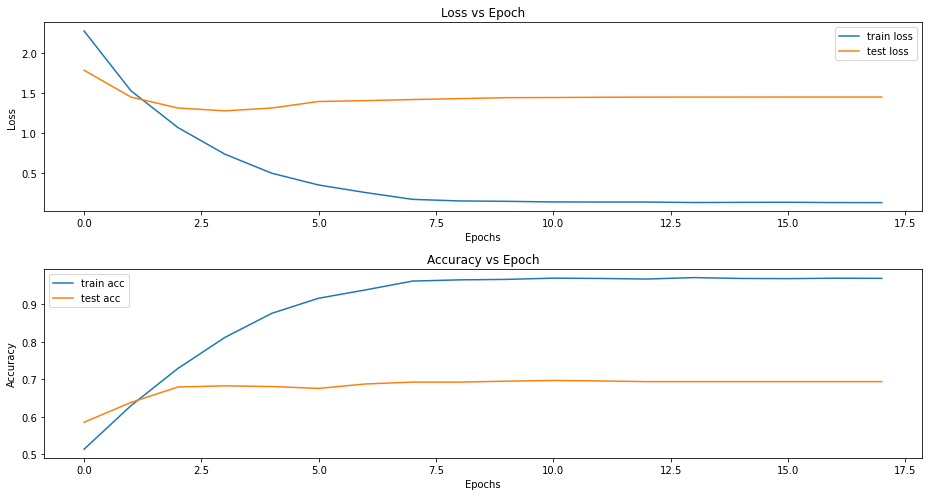

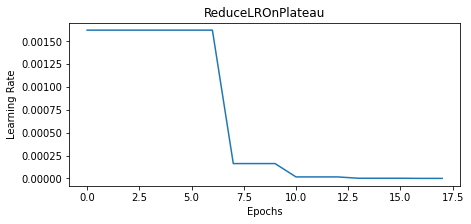

In [ ]:
show_training(model5.history.history,saveit=True,filename='model5_hist')

**Loading saved checkpoint:**

In [ ]:
saved_checkpoint_model5 = load_model("/content/drive/MyDrive/Automatic Ticket Assignment/Model/model checkpoints/model5.h5")

**Evaluating our metrics:**

In [ ]:
ytr_pred = saved_checkpoint_model5.predict(x_train)
yte_pred = saved_checkpoint_model5.predict(x_test)

print("Train set performance:")
DL_evaluation_metrics(y_train, ytr_pred, "ovo", "macro")

print("\nTest set performance:")
DL_evaluation_metrics(y_test, yte_pred, "ovo", "macro")

print("\n**As explained in part2a - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9752798507462687
(macro) ROC-AUC: 0.999779393903313
(macro) F1 Score: 0.9575847723733336

Test set performance:
Accuracy: 0.697139303482587
(macro) ROC-AUC: 0.942417674736818
(macro) F1 Score: 0.5388389768286452

**As explained in part2a - micro-metrics will be similar to accuracy


**So on TEST SET the best accuracy that we got is 69.71 %. This is also equivalent to all the Micro Metrics; as explained in part2a.**<br>We said that Micro is the overall performance of the model despite having imbalanced classification, Macro on the other hand reflects the effect of imbalance in classes. Macro f1-score is 53.88 % while OneVSOne AUC is 94% on the TEST SET <br><br>
**While we are at it, lets also see the remaining metrics on the TRAIN and TEST SETS:**

In [ ]:
print("Train set:\n")
print(classification_report(y_true=y_train.argmax(axis=1), y_pred=ytr_pred.argmax(axis=1)))
print("\nTest set:\n")
print(classification_report(y_true=y_test.argmax(axis=1), y_pred=yte_pred.argmax(axis=1)))

Train set:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2743
           1       0.96      0.96      0.96        25
           2       0.96      0.98      0.97       112
           3       1.00      0.96      0.98        24
           4       0.98      0.98      0.98       205
           5       0.99      1.00      1.00       116
           6       0.99      0.99      0.99        94
           7       1.00      0.97      0.98        30
           8       0.99      1.00      0.99        68
           9       1.00      1.00      1.00        54
          10       1.00      1.00      1.00        70
          11       0.99      0.96      0.98       171
          12       0.98      0.96      0.97       193
          13       1.00      0.97      0.98        29
          14       1.00      0.95      0.98        22
          15       1.00      1.00      1.00        25
          16       0.87      1.00      0.93        20
          17   

**Talking of TEST SET performance**, we can see the effects of class imbalance and lack of data that we have.<br>
**Macro precision** is 59% while **Macro recall** is 53% .<br>**Weighted metrics** are almost similar to **Micro**, around 68-70 %. **Micro metrics** as we discussed in part2a will be exactly equal to the accuracy which is ~70%

#### **Concluding it:**<br>
#### Overall, the performance of the model on test set is 70% despite having class imbalance and lack of data. We know how deep learning is data hungry and training on a dataset of size 6432 records (80% train set) does not provide as good metrics as one would expect but given the dataset we have, 94.24% Macro AUC seems fair.<br>
#### Weighted metrics also seem fair with 68% precision, 70% recall and 68% f1-score on the test set<br>

## **Next-Up:**<br>
### As you can incur from the classification report of train and test set, that the metrics obtained for some classes doesn't have much data to 'support' **(Look at support column of the report)**
### **Hence in the light of imbalance in target classes, we will upsample the minority classes** a bit for the model to train from it. We will take the **same model_5 ahead in part 3 along with the learning rate (0.00162)** that we found in this notebook